<a href="https://colab.research.google.com/github/Vaniotosta/PROJETO-DE-ESTUDO-DEEP-LEARNING-PREVIS-O-DE-DEMANDA-LSTM/blob/main/Previs%C3%A3o_de_demanda_com_series_temporais7v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREVISÃO DE DEMANDA USANDO SÉRIES TEMPORAIS


## OBJETIVO:
- Prever a demanda de uma item es tomando sua quantidade de vendas.
- Os dados se encontra no link;
https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data



 Os dados refere-se a ;
- data - Data dos dados de venda. Não há efeitos de feriados ou fechamentos de lojas.
-loja  - ID da loja
-item - ID do item
- vendas - Número de itens vendidos em uma loja específica em uma data específica.

 ## JUSTIFICATIVA
- Com previsões precisas, empresas e organizações podem identificar tendências futuras, o que é crucial para planejamento estratégico.
- Tomar decisões com base em previsões pode ajudar a mitigar riscos, especialmente em setores como finanças, onde a previsão de preços de ações ou taxas de câmbio é vital.

## Criando diretório para baixar os arquivos via API do kaggle!

In [1]:
# criar diretórios (pastas) no servidor
!mkdir -p /root/.kaggle/

# Mover a API "kaggle.json" para a pasta "kaggle"
!mv kaggle.json /root/.kaggle/



mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle competitions download -c demand-forecasting-kernels-only

demand-forecasting-kernels-only.zip: Skipping, found more recently modified local copy (use --force to force download)


## Descompactando arquivos

In [3]:
# Etapa 5: Descompacte os arquivos baixados
import zipfile

with zipfile.ZipFile('demand-forecasting-kernels-only.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## Importando as bibliotecas

In [4]:
# 1. Importação de bibliotecas e carregamento de dados
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import plotly.express as px

In [5]:
!pip install -U kaleido

In [6]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'colab'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [7]:
pio.renderers.default = "png" # visualizar em outra IDE

In [8]:
# Carregando os dados
df = pd.read_csv('train.csv')
print(df.head())

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


#Explorando os dados

In [9]:
# Informações básicas sobre o dataset
print(df.info())

# Estatísticas descritivas
print(df.describe())

# Verifique se há valores nulos
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None
               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000
date     0
store    0
item     0
sales    0
dtype: int64


- *#  Terei que transformar date em datetime, e não temos dados nulos **

- Temos 10 lojas , 50 itens  e 231 quantidade de itens vendidos
- existem item que vendem muito mais que outros(231), ierei investigar

In [10]:
# Certifique-se de que a coluna de data está em formato de data
df['date'] = pd.to_datetime(df['date'])  # Substitua 'data' pelo nome da coluna de data

# Encontre as datas mínimas e máximas
data_minima = df['date'].min()
data_maxima = df['date'].max()

print(f'Data mínima: {data_minima}')
print(f'Data máxima: {data_maxima}')

Data mínima: 2013-01-01 00:00:00
Data máxima: 2017-12-31 00:00:00


- Aqui que existem uma série temporal de 5 anos.

In [11]:
variables = ['store', 'item', 'date']

# Iterar sobre cada variável e contar as ocorrências
for var in variables:
    counts = df[var].value_counts()
    print(f"Número de vendas por {var}:")
    print(counts)
    print()

Número de vendas por store:
store
1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: count, dtype: int64

Número de vendas por item:
item
1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: count, dtype: int64

Número de vendas por date:
date
2017-12-31    500
2013-01-01    500
2017-11-22    500
2017-11-23    500
2017-11-24    500
             ... 
2013-01-06    500
20

Total de vendas por ano:
   year     sales
0  2013   7941243
1  2014   9135482
2  2015   9536887
3  2016  10357160
4  2017  10733740


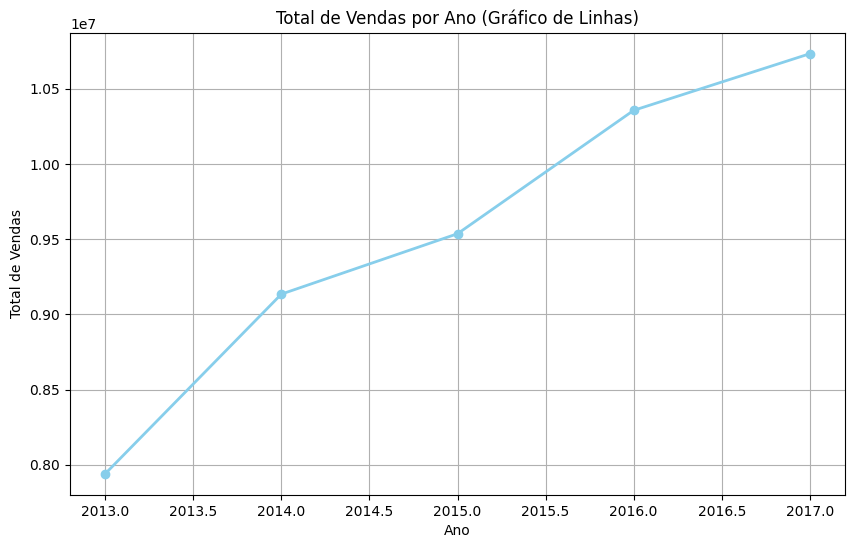

In [12]:
# Extrair o ano da coluna 'date'
df['year'] = df['date'].dt.year

# Agrupar vendas por ano e calcular o total
sales_by_year = df.groupby('year')['sales'].sum().reset_index()

# Exibir o total de vendas por ano
print("Total de vendas por ano:")
print(sales_by_year)

# Gerar gráfico de linhas dos totais de vendas por ano
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year['year'], sales_by_year['sales'], marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Ano')
plt.ylabel('Total de Vendas')
plt.title('Total de Vendas por Ano (Gráfico de Linhas)')
plt.grid(True)
plt.show()

- Todos os anos existiram aumentos das qtd vendidas, vendas crescente com destaque ao ano de 2017

-  As lojas 8, 9 e 10 são as que mais vendem em todos anos, todas anos com lojas em quantidades crescente

Aqui percebe-se que  2017 se destaca em qtidades vendidas,Confirmando o tem 48,49 e 50 como mais vendidos

## Analise do item 50 considerado um dos mais vendidos

O item 50, varia de **200 mil** qtdades vendida em 2013, e cresce para **269 mil** qtidades de vendas em 2017, ou seja, quase o dobro do segundo colocado

## Analise do item 49 considerado um dos mais vendidos

O item 50, varia de **88 mil** qtdades vendida em 2013, e cresce para **120 mil** qtidades de vendas em 2017, ou sejaquase a etade do item 50

###VAMOS PEGAR OS TOP 10 E COMPARAR COM RESTANTE

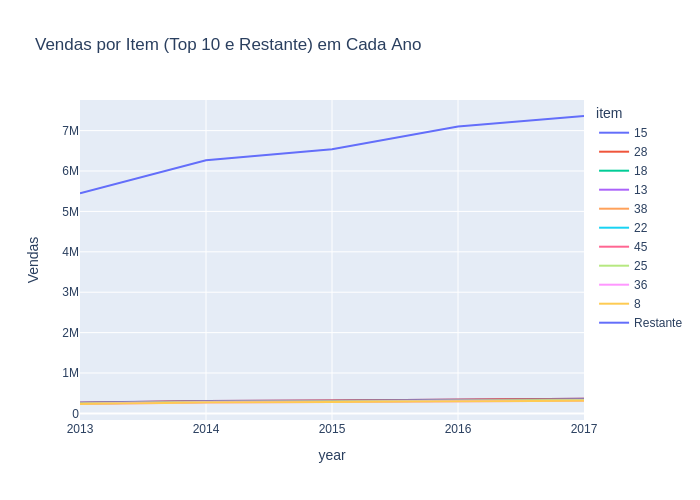

In [13]:
# Agrupe os dados por ano, item e calcule a soma das vendas
df_grouped = df.groupby(['year', 'item'])['sales'].sum().reset_index()

# Ordene os itens pelo total de vendas em ordem decrescente
df_grouped = df_grouped.sort_values(by=['year', 'sales'], ascending=[True, False])

# Separe os 10 maiores itens
top_10_items = df_grouped.groupby('year').head(10)

# Calcule a soma do restante dos itens
resto_items = df_grouped[~df_grouped['item'].isin(top_10_items['item'])]
soma_resto = resto_items.groupby(['year'])['sales'].sum().reset_index()
soma_resto['item'] = 'Restante'

# Concatene os 10 maiores itens com a soma do restante
df_combined = pd.concat([top_10_items, soma_resto])

# Crie o gráfico de linhas usando Plotly
fig = px.line(df_combined, x='year', y='sales', color='item',
              labels={'sales': 'Vendas', 'Ano': 'Ano'},
              title='Vendas por Item (Top 10 e Restante) em Cada Ano')

# Mostre o gráfico
fig.show()


Como as quantidades vendidas dos top 10 são inferiores aos dos restante, não é viável analisar apenas top 10

## PARA MELHOR ANÁLISE CRIEI UMA TABELA COM A SOMATÓRIA DAS VENDAS

In [14]:
# Crie uma tabela de frequência usando pivot_table
tabela_frequencia = pd.pivot_table(df, values='sales', index='item', columns='year', aggfunc='sum', fill_value=0)

# Calcule as vendas totais por produto em todos os anos
tabela_frequencia['Total_Vendas'] = tabela_frequencia.sum(axis=1)

# Ordene a tabela com base nas vendas totais por produto
tabela_frequencia = tabela_frequencia.sort_values(by='Total_Vendas', ascending=False)

# Remova a coluna 'Total_Vendas' se não for necessária na visualização
tabela_frequencia = tabela_frequencia.drop(columns='Total_Vendas')

# Mostre a tabela de frequência ordenada
print(tabela_frequencia)

year    2013    2014    2015    2016    2017
item                                        
15    267529  308098  321469  348760  361586
28    267152  308011  320622  348160  360768
13    256064  294991  307571  334430  346565
18    256583  294570  307134  334141  346448
25    244552  282702  294428  320866  330786
45    244735  281365  294265  319319  331783
38    245280  281181  293774  319090  331005
22    245129  281628  293800  319518  329896
36    233656  269707  281563  305427  316195
8     233425  269312  280726  304734  316911
10    222071  255917  266770  290514  301861
11    211978  242814  253808  276443  286882
12    212274  243266  254515  275645  285834
29    211483  243510  254084  275695  286468
33    211338  243543  254217  275085  286000
24    201321  230401  241350  261968  270935
50    200490  230733  240403  261444  269939
35    199920  230226  240121  260670  270604
14    178521  204649  214360  232879  241122
31    178297  205156  214290  232484  240618
46    1788

Aqui percebemos que o item 15 e 28 são os que mais lideram em quantidades de vendas

## BUSCANDO O ITEM MAIS VENDIDO

In [15]:
# Crie uma tabela de frequência usando pivot_table
tabela_frequencia = pd.pivot_table(df, values='sales', index='item', columns=['year', 'store'], aggfunc='sum', fill_value=0)

# Encontre o item mais vendido para cada loja em cada ano
itens_mais_vendidos = tabela_frequencia.idxmax(axis=0)

# Mostre a tabela de itens mais vendidos por loja em cada ano
print(itens_mais_vendidos)

year  store
2013  1        28
      2        15
      3        28
      4        15
      5        15
      6        15
      7        28
      8        15
      9        15
      10       15
2014  1        28
      2        28
      3        28
      4        28
      5        15
      6        15
      7        28
      8        28
      9        15
      10       15
2015  1        28
      2        28
      3        15
      4        15
      5        28
      6        28
      7        15
      8        15
      9        15
      10       15
2016  1        15
      2        15
      3        28
      4        28
      5        15
      6        15
      7        15
      8        15
      9        28
      10       28
2017  1        15
      2        15
      3        15
      4        15
      5        28
      6        28
      7        15
      8        28
      9        15
      10       28
dtype: int64


Acima validamos que os itens 15 e 28 , são os que mais vendem, e por isso vamos analisá-los em separados

## VERIFICANDO OS ITEM 15 COMO MAIS VENDIDO POR ANO

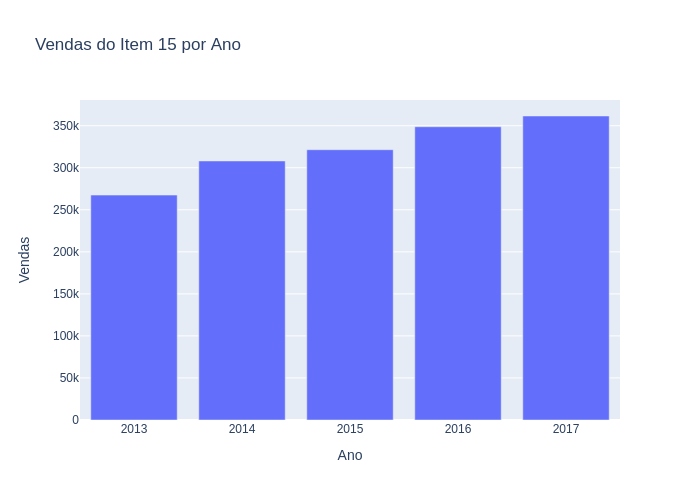

In [16]:
# ITENS MAIS VENDIDOS
# Filtrar o DataFrame para mostrar apenas o item 49
item_filtrado = df[df['item'] == 15]

# Agrupe os dados do item 15 por ano e calcule a soma das vendas
df_grouped = item_filtrado.groupby(['year'])['sales'].sum().reset_index()

# Criar o gráfico de barras usando Plotly
fig = px.bar(df_grouped, x='year', y='sales',
             labels={'sales': 'Vendas', 'year': 'Ano'},
             title='Vendas do Item 15 por Ano')

# Mostrar o gráfico
fig.show()

Vendas crescentes, com destaque ao ano de 2017 com **361 mil** vendas

## ANALISANDO SEGUNDO MAIOR ITEM DE VENDAS

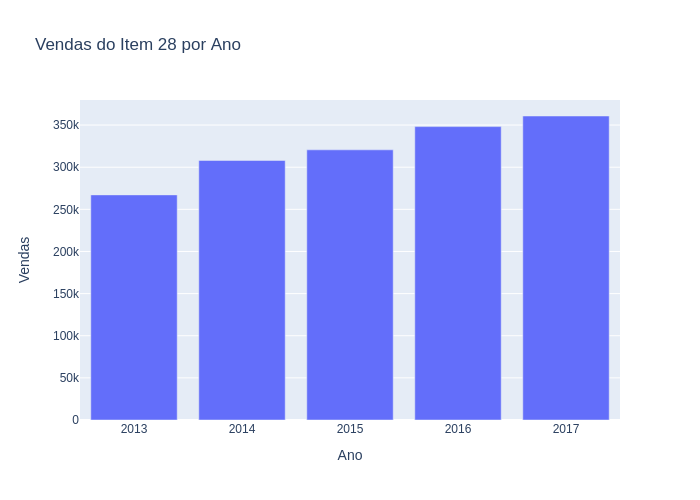

In [17]:
# SEGUNDO ITENS MAIS VENDIDOS
# Filtrar o DataFrame para mostrar apenas o item 49
item_filtrado = df[df['item'] == 28]

# Agrupe os dados do item 128 por ano e calcule a soma das vendas
df_grouped = item_filtrado.groupby(['year'])['sales'].sum().reset_index()

# Criar o gráfico de barras usando Plotly
fig = px.bar(df_grouped, x='year', y='sales',
             labels={'sales': 'Vendas', 'year': 'Ano'},
             title='Vendas do Item 28 por Ano')

# Mostrar o gráfico
fig.show()

Vendas crescentes, com destaque ao ano de 2017 com **360 mil** vendas, qtd de vendas muito próximo do líder

## COMO ESTRATÉGIA DE NEGÓCIO  VAMOS USAR O ITEM 15, POR SER O LIDER DE QTD VENDIDAS PARA PREVISÃO

### **Obs:** Escolheremos realizar a Predição do Item 15 (mais vendido) na loja "1".

Caso precise, podemos realizar o mesmo procedimento para  os demais produtos.usando a mesma  metodologia: Basta trocar o item e a store.

#PROCESAMENTO DOS DADOS
Vamos buscar o item 15 da loja 1

In [ ]:
# Carregando os dados
df = pd.read_csv('train.csv')
print(df.head())

# 2. Pré-processamento dos dados
# Para simplificar, vamos pegar as vendas de um único item de uma única loja como exemplo
single_series = df[(df['store'] == 1) & (df['item'] == 15)]['sales'].values.reshape(-1, 1)

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


In [ ]:
single_series # srie simples do item 15 da loja 1

array([[42],
       [33],
       [45],
       ...,
       [65],
       [77],
       [64]])

## Escala dos dados

### Escalonamento dos Dados:
Os dados são normalizados para o intervalo entre 0 e 1 para melhorar o desempenho do modelo e garantir que todas as características contribuam igualmente.
Divisão em Treino e Teste: Os dados são divididos em conjuntos de treino e teste com uma proporção de 67% para treino e 33% para teste.

Isso permite treinar o modelo em uma parte dos dados e avaliá-lo em outra parte não vista.
Este processo é fundamental para treinar e validar modelos , garantindo que o modelo generalize bem para novos dados e não apenas memorize o conjunto de treino. Se precisar de mais detalhes ou tiver outras dúvidas, estou à disposição!


In [ ]:
from sklearn.metrics import r2_score


# Escalando os dados entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(single_series)

# Dividindo em treino e teste
train_size = int(len(scaled_series) * 0.67)
test_size = len(scaled_series) - train_size
train, test = scaled_series[0:train_size,:], scaled_series[train_size:len(scaled_series),:]

####A função create_dataset transforma uma série temporal em um conjunto de dados para treinamento de uma LSTM. Ela cria pares de entrada (X) e saída (Y), onde a entrada é uma sequência de valores anteriores e a saída é o valor seguinte na série temporal.

In [ ]:
# Função para criar dataset para a LSTM UNIVARIAVDAS
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape para [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


def create_multivariate_dataset(dataset, look_back=1):    FUNÇÃO MULTIVARIADAS
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])  # Assumindo que a última coluna é o alvo
    return np.array(dataX), np.array(dataY)


In [ ]:
# FUNÇÃO PARA MULTIVARIADAS

#def create_multivariate_dataset(dataset, look_back=1):
    #dataX, dataY = [], []
    #for i in range(len(dataset)-look_back-1):
        #a = dataset[i:(i+look_back)]
        #dataX.append(a)
        #dataY.append(dataset[i + look_back, -1])  # Assumindo que a última coluna é o alvo
    #return np.array(dataX), np.array(dataY)


# Desenvolvimento do modelo Preditivo com LSTM


Definimos um modelo sequencial.
Adicionamos uma camada LSTM com 50 neurônios e uma camada densa de saída com 1 neurônio.
Compilação do Modelo:

Compilamos o modelo com mean_squared_error como função de perda, adam como otimizador e mean_absolute_error como métrica adicional.
Treinamento do Modelo:

Treinamos o modelo por 3 épocas com um tamanho de lote de 16.
Avaliação e Predição:

Usamos o modelo treinado para fazer previsões nos dados de treino e teste.

In [ ]:
# 3. Construção do modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))

# Adicionando a métrica mean_absolute_error
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.mean_absolute_error])

# 4. Treinamento do modelo
model.fit(trainX, trainY, epochs=3, batch_size=16, verbose=2)

# 5. Avaliação e predição
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/3
77/77 - 7s - loss: 0.0644 - mean_absolute_error: 0.2017 - 7s/epoch - 88ms/step
Epoch 2/3
77/77 - 0s - loss: 0.0132 - mean_absolute_error: 0.0922 - 245ms/epoch - 3ms/step
Epoch 3/3
77/77 - 0s - loss: 0.0131 - mean_absolute_error: 0.0918 - 251ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step


A redução significativa no valor de loss e MAE da primeira para a segunda época indica que o modelo está aprendendo bem e se ajustando aos dados de treino.
A pequena redução nos valores de loss e MAE da segunda para a terceira época sugere que o modelo está se aproximando de uma convergência.

## Avaliando o modelo

In [ ]:
# Inversão das previsões para escala original
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

# Cálculo do RMSE
trainScore = np.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# Calcula o R² para o conjunto de treinamento
trainR2 = r2_score(trainY_orig[0], trainPredict[:, 0])
print('Train R²: %.2f' % (trainR2))

# Calcula o R² para o conjunto de teste
testR2 = r2_score(testY_orig[0], testPredict[:, 0])
print('Test R²: %.2f' % (testR2))

Train RMSE: 15.66
Test RMSE: 19.42
Train R²: 0.36
Test R²: 0.16


- O modelo explica 16% da variabilidade nos dados de teste. Isso sugere que o modelo não generaliza bem para novos dados, o que pode indicar um problema de overfitting (o modelo se ajustou muito bem aos dados de treino, mas não generaliza bem para dados não vistos).

- O RMSE é maior nos dados de teste (19,42) em comparação com os dados de treino (15.66), indicando que o modelo tem um desempenho pior em dados não vistos.
O R² é menor nos dados de teste (0.16) do que nos dados de treino (0.36), reforçando a ideia de que o modelo não generaliza bem.

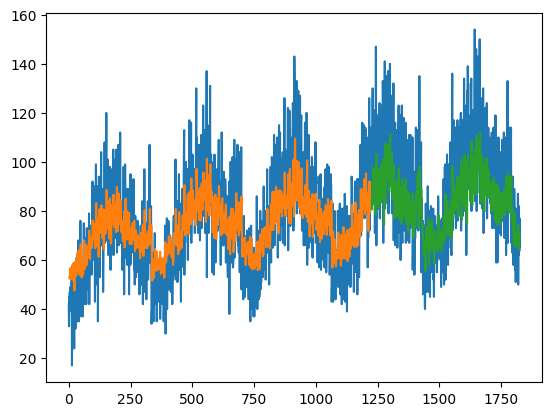

In [ ]:
# Plot das previsões
plt.plot(scaler.inverse_transform(scaled_series))
trainPredictPlot = np.empty_like(scaled_series)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(scaled_series)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled_series)-1, :] = testPredict

plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Observando os dados originais, Existe margem  para  melhorar o modelo

#MELHORANDO O MODELO

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import plotly.graph_objects as go

# Certifique-se de que a coluna 'date' está em formato de data
df['date'] = pd.to_datetime(df['date'])

# Extraia o ano da coluna 'date' e crie uma nova coluna 'Ano'
df['Ano'] = df['date'].dt.year

# Extraia a série temporal de vendas
single_series = df['sales'].values.reshape(-1, 1)

# Escalando os dados entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(single_series)
scaled_series

array([[0.05627706],
       [0.04761905],
       [0.06060606],
       ...,
       [0.32034632],
       [0.26839827],
       [0.35497835]])

#### Tunagem de Parâmetros do Modelo

- TimeSeriesSplit é usado para criar splits de validação cruzada que respeitam a ordem temporal dos dados. Isso é importante para séries temporais, onde não se deve misturar dados de diferentes pontos no tempo entre treino e validação

In [ ]:
# Defina as combinações de hiperparâmetros que deseja testar
param_grid = {
    'num_units': [50],           # Número de unidades na camada LSTM
    'learning_rate': [0.001],   # Taxa de aprendizado
    'epochs': [5],                # Número de épocas
    'batch_size': [128]            # Tamanho do lote
}

# Divida sua série temporal em folds usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 folds como exemplo

best_model = None
best_rmse = float('inf')

# Função para criar dataset para a LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Função para avaliar o modelo no conjunto de teste
def evaluate_model_on_test(model, scaled_series, look_back, scaler):
    train_size = int(len(scaled_series) * 0.67)  # Defina a proporção desejada para treinamento
    test_size = len(scaled_series) - train_size

    test = scaled_series[train_size:len(scaled_series), :]

    testX, testY = create_dataset(test, look_back)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Previsões no conjunto de teste
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Cálculo do RMSE
    test_rmse = np.sqrt(mean_squared_error(testY_orig[0], testPredict[:, 0]))

    # Cálculo do R²
    test_r2 = r2_score(testY_orig[0], testPredict[:, 0])

    return test_rmse, test_r2

#### Rodar o Modelo Preditivo e Avaliá-lo

In [ ]:
# Execute a pesquisa de hiperparâmetros
for params in ParameterGrid(param_grid):
    rmse_scores = []
    r2_scores = []

    for train_index, test_index in tscv.split(scaled_series):
        train, test = scaled_series[train_index], scaled_series[test_index]

        look_back = 3
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # Construção do modelo LSTM
        model = Sequential()
        model.add(LSTM(params['num_units'], input_shape=(1, look_back)))
        model.add(Dense(1))

        # Compilação do modelo
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']))

        # Treinamento do modelo
        model.fit(trainX, trainY, epochs=params['epochs'], batch_size=params['batch_size'], verbose=2)

        # Avaliação do modelo
        test_rmse, test_r2 = evaluate_model_on_test(model, scaled_series, look_back, scaler)

        rmse_scores.append(test_rmse)
        r2_scores.append(test_r2)

    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Se a média do RMSE for a melhor até agora, armazene o modelo e os hiperparâmetros
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_r2 = mean_r2
        best_model = model
        best_params = params

# Avalie o modelo final no conjunto de teste
test_rmse, test_r2 = evaluate_model_on_test(best_model, scaled_series, look_back, scaler)

# Exiba os melhores hiperparâmetros, o RMSE e o R² no conjunto de teste
print("Melhores Hiperparâmetros:", best_params)
print("RMSE no Conjunto de Teste:", test_rmse)
print("R² no Conjunto de Teste:", test_r2)


Epoch 1/5
1189/1189 - 6s - loss: 0.0035 - 6s/epoch - 5ms/step
Epoch 2/5
1189/1189 - 4s - loss: 0.0023 - 4s/epoch - 3ms/step
Epoch 3/5
1189/1189 - 4s - loss: 0.0023 - 4s/epoch - 3ms/step
Epoch 4/5
1189/1189 - 4s - loss: 0.0023 - 4s/epoch - 3ms/step
Epoch 5/5
1189/1189 - 4s - loss: 0.0023 - 4s/epoch - 3ms/step
9416/9416 [==============================] - 18s 2ms/step
Epoch 1/5
2378/2378 - 10s - loss: 0.0038 - 10s/epoch - 4ms/step
Epoch 2/5
2378/2378 - 10s - loss: 0.0030 - 10s/epoch - 4ms/step
Epoch 3/5
2378/2378 - 9s - loss: 0.0030 - 9s/epoch - 4ms/step
Epoch 4/5
2378/2378 - 10s - loss: 0.0030 - 10s/epoch - 4ms/step
Epoch 5/5
2378/2378 - 9s - loss: 0.0030 - 9s/epoch - 4ms/step
9416/9416 [==============================] - 19s 2ms/step
Epoch 1/5
3567/3567 - 13s - loss: 0.0037 - 13s/epoch - 4ms/step
Epoch 2/5
3567/3567 - 13s - loss: 0.0031 - 13s/epoch - 4ms/step
Epoch 3/5
3567/3567 - 12s - loss: 0.0031 - 12s/epoch - 3ms/step
Epoch 4/5
3567/3567 - 12s - loss: 0.0031 - 12s/epoch - 3ms/step
Ep

- O modelo treinado com os melhores hiperparâmetros (batch_size: 128, epochs: 5, learning_rate: 0.001, num_units: 50) foi capaz de explicar 81.6% da variabilidade nos dados de resposta, o que é um bom desempenho.
- O RMSE de 11.63 sugere que o modelo faz previsões razoavelmente precisas, mas há espaço para melhorias.

##### Visualisar o Gráfico da Previsão

In [ ]:
# Plot da Previsão

def plot_predictions(original_series, train_predict, test_predict, scaler, look_back):
    # Invertendo a escala para a forma original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Preparando a estrutura para o plot
    train_plot = np.empty_like(original_series, dtype=np.float32)
    train_plot[:, :] = np.nan
    train_plot[look_back:len(train_predict)+look_back, :] = train_predict

    test_plot = np.empty_like(original_series, dtype=np.float32)
    test_plot[:, :] = np.nan
    test_plot[len(train_predict)+(look_back*2)+1:len(original_series)-1, :] = test_predict

    # Plotagem usando o plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=np.arange(len(original_series)), y=original_series.flatten(), mode='lines', name='Original Series'))
    fig.add_trace(go.Scatter(x=np.arange(look_back, len(train_predict)+look_back), y=train_plot.flatten(), mode='lines', name='Train Predictions'))
    fig.add_trace(go.Scatter(x=np.arange(len(train_predict)+(look_back*2)+1, len(original_series)-1), y=test_plot.flatten(), mode='lines', name='Test Predictions'))

    fig.update_layout(title='Real vs. Previsões de Treino vs. Previsões de Teste', xaxis_title='Número de Dias desde o Início da Série', yaxis_title='Quantidade')
    fig.show()

# No final do código, chame a função de plotagem
look_back = 3
train_size = int(len(scaled_series) * 0.67)
test_size = len(scaled_series) - train_size

train, test = scaled_series[0:train_size,:], scaled_series[train_size:len(scaled_series),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)

plot_predictions(single_series, trainPredict, testPredict, scaler, look_back)

9416/9416 [==============================] - 19s 2ms/step


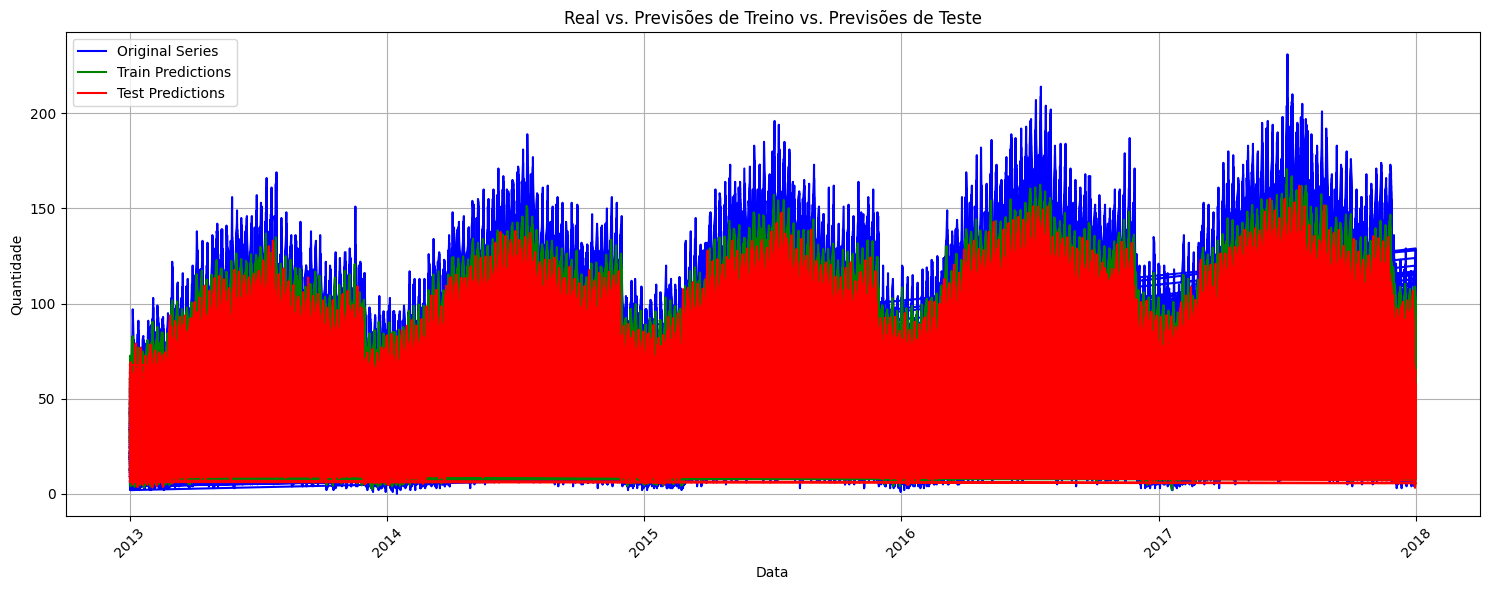

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions_with_matplotlib(dates, original_series, train_predict, test_predict, scaler, look_back):
    # Invertendo a escala para a forma original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Preparando a estrutura para o plot
    train_plot = np.empty_like(original_series, dtype=np.float32)
    train_plot[:, :] = np.nan
    train_plot[look_back:len(train_predict) + look_back, 0] = train_predict[:, 0]

    test_plot = np.empty_like(original_series, dtype=np.float32)
    test_plot[:, :] = np.nan
    test_plot[len(train_predict) + (look_back * 2):len(train_predict) + (look_back * 2) + len(test_predict), 0] = test_predict[:, 0]

    # Plotagem usando matplotlib
    plt.figure(figsize=(15, 6))
    plt.plot(dates, original_series, label='Original Series', color='blue')
    plt.plot(dates, train_plot, label='Train Predictions', color='green')
    plt.plot(dates, test_plot, label='Test Predictions', color='red')
    plt.title('Real vs. Previsões de Treino vs. Previsões de Teste')
    plt.xlabel('Data')
    plt.ylabel('Quantidade')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para melhor visualização.
    plt.tight_layout()
    plt.show()

# No final do código, chame a nova função de plotagem usando as datas do DataFrame original
dates = df['date'].values
plot_predictions_with_matplotlib(dates, single_series, trainPredict, testPredict, scaler, look_back)


Aqui são os resultados dos dados de treino e teste, é ideal obrsevar graficamente

Observando os dados de treino e teste,eles seguem generalizando bem, isso indica o bom modelo, ainda existem margem comparando-se ao dados originais

#Previsão da Demanda do produto
- Fazer previsões da loja 1 , item 15 para os próximos **7 DIAS**

1/1 [==============================] - 0s 24ms/step
         Data   Previsão
0  2018-01-02  74.544952
1  2018-01-03  74.240486
2  2018-01-04  75.905869
3  2018-01-05  75.173141
4  2018-01-06  75.224922
5  2018-01-07  75.369591
6  2018-01-08  75.310768
7  2018-01-09  75.332489
8  2018-01-10  75.354424
9  2018-01-11  75.359306
10 2018-01-12  75.371712
11 2018-01-13  75.383049
12 2018-01-14  75.392662
13 2018-01-15  75.402618
14 2018-01-16  75.412056
15 2018-01-17  75.421021
16 2018-01-18  75.429695
17 2018-01-19  75.437996
18 2018-01-20  75.445938
19 2018-01-21  75.453583
20 2018-01-22  75.460907
21 2018-01-23  75.467926
22 2018-01-24  75.474670
23 2018-01-25  75.481133
24 2018-01-26  75.487328
25 2018-01-27  75.493279
26 2018-01-28  75.498978
27 2018-01-29  75.504448
28 2018-01-30  75.509697
29 2018-01-31  75.514725


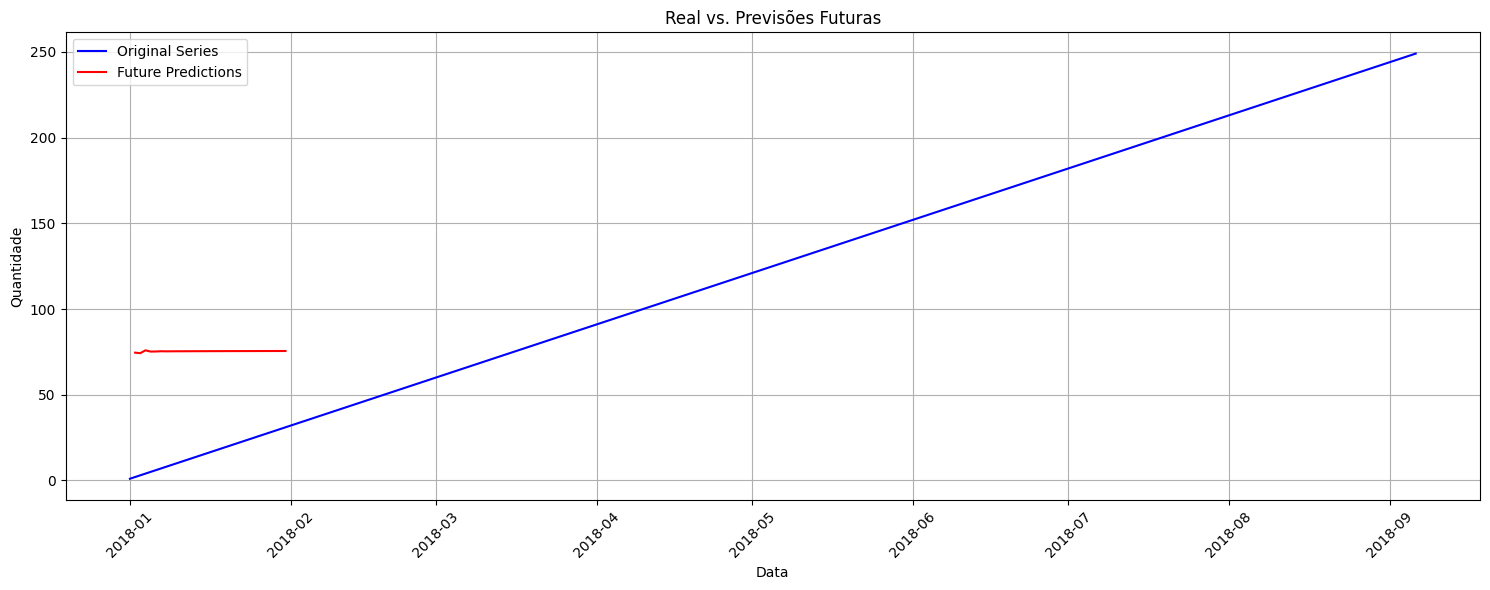

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import datetime

# Função para gerar previsões para os próximos 'num_days' dias
def forecast_next_days(model,scaler, look_back, num_days):
    # Escalar a série original
    scaler = MinMaxScaler(feature_range=(0, 1))
    series_scaled = scaler.fit_transform(single_series)

    # Obter os últimos 'look_back' valores dos dados de teste
    last_data = series_scaled[-look_back:]

    # Lista para armazenar as previsões futuras
    future_predictions = []

    for _ in range(num_days):
        # Reshape para a entrada do modelo
        input_data = np.reshape(last_data, (1, 1, look_back))

        # Fazer a previsão
        next_prediction = model.predict(input_data)

        # Adicionar a previsão à lista de previsões futuras
        future_predictions.append(next_prediction[0, 0])

        # Atualizar 'last_data' para incluir a nova previsão
        last_data = np.append(last_data[1:], next_prediction)

    # Inverter a escala das previsões futuras
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

# Exemplo de uso da função para prever os próximos 30 dias
num_days = 30

# Supondo que 'original_series' seja uma série temporal em formato de array 2D, por exemplo: [[value1], [value2], ...]
original_series = np.array([[value] for value in range(1, 250)])  # Exemplo de série temporal
look_back = 3  # Exemplo de look_back



# Carregue seu modelo treinado aqui, se necessário

# Gerar previsões para os próximos 10 dias
future_predictions = forecast_next_days(best_model, original_series, look_back, num_days)

# Criar um DataFrame com as datas e as previsões
last_date = pd.to_datetime('2018-01-01')  # Data final da série original (substitua conforme necessário)
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')
future_predictions_df = pd.DataFrame({'Data': future_dates, 'Previsão': future_predictions.flatten()})

# Exibir as previsões futuras
print(future_predictions_df)

# Função para plotar as previsões
def plot_predictions_with_matplotlib(dates, original_series, future_dates, future_predictions):
    plt.figure(figsize=(15, 6))
    plt.plot(dates, original_series, label='Original Series', color='blue')
    plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')
    plt.title('Real vs. Previsões Futuras')
    plt.xlabel('Data')
    plt.ylabel('Quantidade')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para melhor visualização.
    plt.tight_layout()
    plt.show()

# Datas da série original
original_dates = pd.date_range(start='2018-01-01', periods=len(original_series), freq='D')  # Substitua pela data inicial correta

# Plotar as previsões futuras
plot_predictions_with_matplotlib(original_dates, original_series.flatten(), future_dates, future_predictions.flatten())


## RESULTADOS DAS PREVISÕES DO MODELO
- Os resultados mostram as previsões do modelo LSTM para os próximos 30 dias a partir de 1º de janeiro de 2018. As previsões estão sendo retornadas para cada dia subsequente até 31 de janeiro de 2018.





- As previsões começam com um valor próximo de 74.54 e gradualmente aumentam até aproximadamente 75.51 no final do período de previsão. Esse padrão sugere que o modelo está prevendo um ligeiro aumento na série temporal ao longo dos próximos 30 dias.

**Estabilidade das Previsões:**

As previsões são bastante estáveis e parecem convergir para um valor próximo de 75.5 após alguns dias. Isso pode indicar que a série temporal subjacente é relativamente estável ou que o modelo está capturando um comportamento estável nos dados.